In [1]:
import glob
import torch
import numpy as np
import scipy as sp
import scipy.io
import scipy.signal
import time
import pandas as pd
import math
from utils.data_utils import *
from utils.viz_utils import *
from model.motionPPGNet import motionPPGNet

from torch import nn
import torch.optim as optim
from scipy.io import loadmat
import matplotlib.pyplot as plt
from matplotlib import figure
from scipy.signal import savgol_filter
from scipy.signal import butter, lfilter
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Import model libs
# from keras.models import Sequential
# from keras.layers import Dense, Conv1D, Dropout, Flatten, MaxPooling1D, BatchNormalization, LSTM
# from keras import optimizers
# from keras.utils import to_categorical
# from keras.utils.vis_utils import plot_model


fs = 125
minBPM = 40
maxBPM = 240
window_length = 8 * fs
window_shift = 2 * fs  #Overlap = window_length - window_shift

# Retrieve dataset files
data_dir = "datasets/troika/training_data"
data_fls, ref_fls = LoadTroikaDataset(data_dir)
errs, confs = [], []

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
# device = "cpu"
print(f"Using {device} device")

Using mps device


(148, 1000)
(148,)


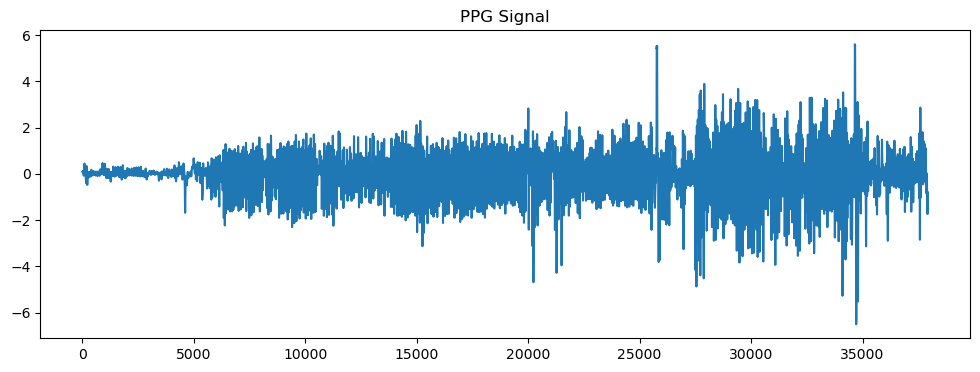

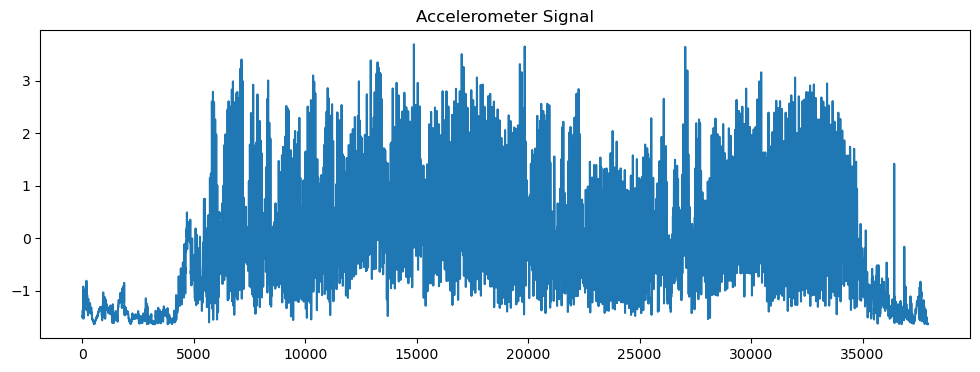

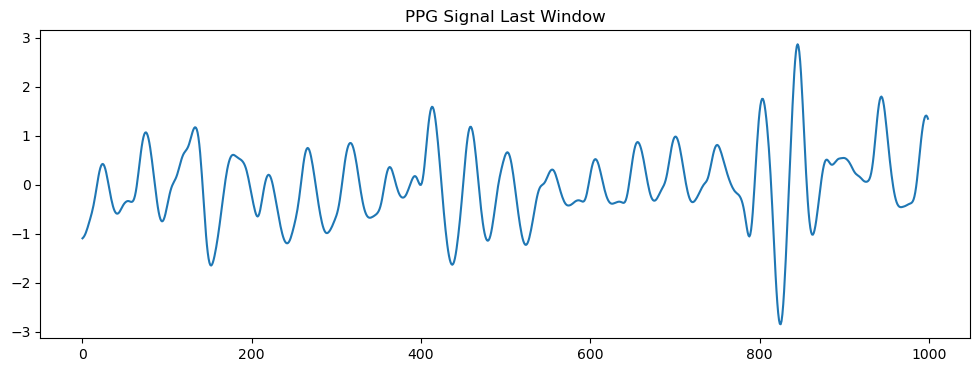

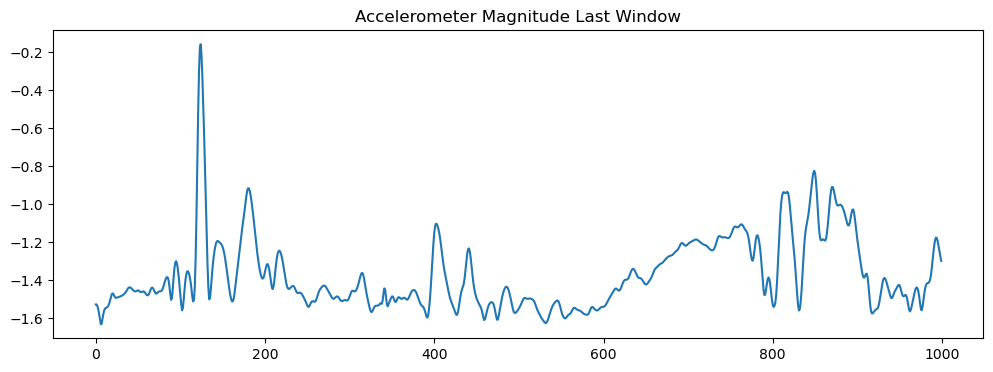

In [20]:
# Load a single data file and visualize preprocessing
data_fl = data_fls[0]
ref_fl = ref_fls[0]

# load data using LoadTroikaDataFile
ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)

# bandpass filter the signals
# TODO Bandpass window above is not being used
ppg = bandpass_filter(ppg, fs)
accx = bandpass_filter(accx, fs)
accy = bandpass_filter(accy, fs)
accz = bandpass_filter(accz, fs)

# Consider only magnitude of acceleration
acc = calculate_magnitude(accx, accy, accz)

# Standardization
ppg = (ppg- np.mean(ppg))/np.std(ppg)
acc = (acc- np.mean(acc))/np.std(acc)

# loading the reference file
ground_truth = sp.io.loadmat(ref_fl)['BPM0'].reshape(-1)

X1 = []
y1 = ground_truth
for i in range(0, len(ppg) - window_length + 1, window_shift):

    # aggregate accelerometer data into single signal to get the acc window
    ppg_window = ppg[i:i+window_length]
    acc_window = acc[i:i+window_length]

    X1.append(ppg_window)


X1 = np.array(X1)
print(X1.shape)
print(y1.shape)

class viz:
    def __init__(self, figsize = None):
        self.figsize = figsize
    def plot(self, value, time_ax = None, title = None):
        plt.figure(figsize=self.figsize)
        if time_ax is not None:
            plt.plot(time_ax, value)
        else:
            plt.plot(value)
        if title:
            plt.title(title)
        plt.show()



# Visualization data for the first and last window
pltviz = viz(figsize=(12, 4))

pltviz.plot(ppg, title="PPG Signal")
pltviz.plot(acc,title = "Accelerometer Signal")

pltviz.plot(ppg_window, title="PPG Signal Last Window")
pltviz.plot(acc_window,title = "Accelerometer Magnitude Last Window")

# single_set_plot(ppg, acc, ground_truth, X1)

In [21]:
# Load all data
X = []
y = []
y = np.array(y)

print(data_fls)
for i in range(len(data_fls)):

    data_fl = data_fls[i]
    ref_fl = ref_fls[i]
    # load data using LoadTroikaDataFile
    ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)

    # bandpass filter the signals
    ppg = bandpass_filter(ppg, fs)
    accx = bandpass_filter(accx, fs)
    accy = bandpass_filter(accy, fs)
    accz = bandpass_filter(accz, fs)

    # Consider only magnitude of acceleration
    acc = calculate_magnitude(accx, accy, accz)

    # Standardization
    ppg = (ppg- np.mean(ppg))/np.std(ppg)
    acc = (acc- np.mean(acc))/np.std(acc)

    # loading the reference file
    ground_truth = sp.io.loadmat(ref_fl)['BPM0'].reshape(-1)
    y = np.append(y, ground_truth)

    for i in range(0, len(ppg) - window_length + 1, window_shift):

        # aggregate accelerometer data into single signal to get the acc window
        ppg_window = ppg[i:i+window_length]
        acc_window = acc[i:i+window_length]

        X.append(ppg_window)


X = np.array(X)
print(X.shape)
print(y.shape)


['datasets/troika/training_data/DATA_01_TYPE01.mat', 'datasets/troika/training_data/DATA_02_TYPE02.mat', 'datasets/troika/training_data/DATA_03_TYPE02.mat', 'datasets/troika/training_data/DATA_04_TYPE01.mat', 'datasets/troika/training_data/DATA_04_TYPE02.mat', 'datasets/troika/training_data/DATA_05_TYPE02.mat', 'datasets/troika/training_data/DATA_06_TYPE02.mat', 'datasets/troika/training_data/DATA_07_TYPE02.mat', 'datasets/troika/training_data/DATA_08_TYPE02.mat', 'datasets/troika/training_data/DATA_10_TYPE02.mat', 'datasets/troika/training_data/DATA_11_TYPE02.mat', 'datasets/troika/training_data/DATA_12_TYPE02.mat']
(1726, 1000)
(1726,)


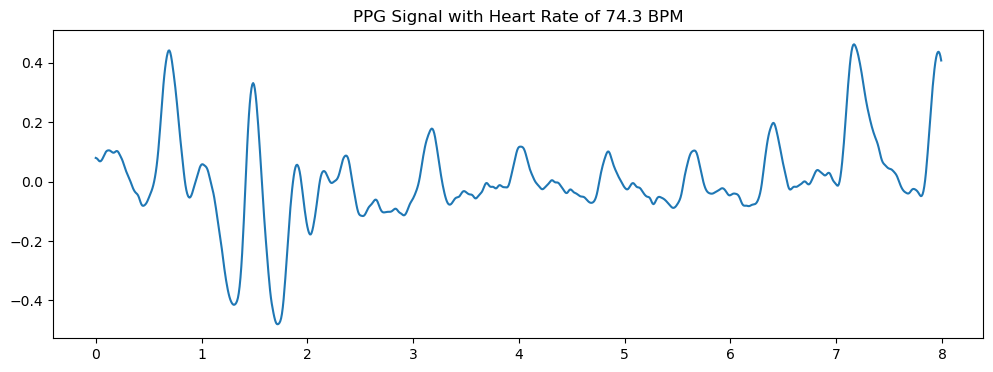

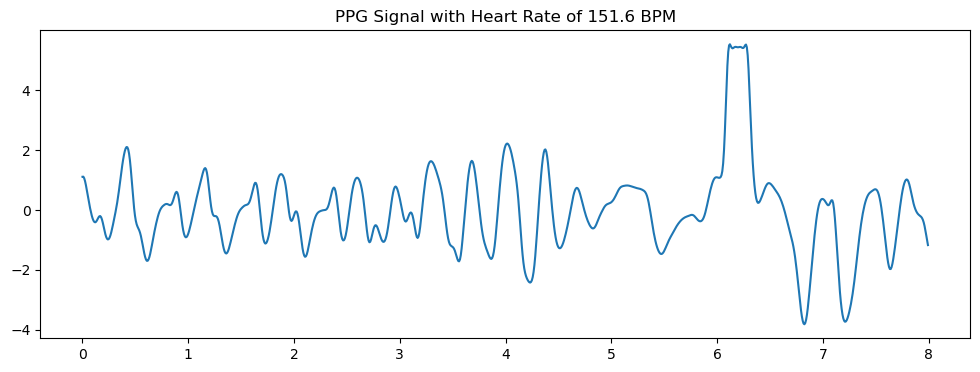

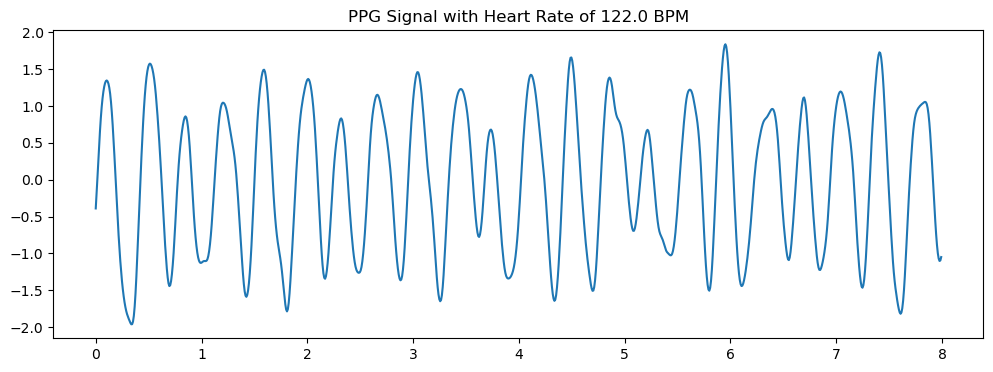

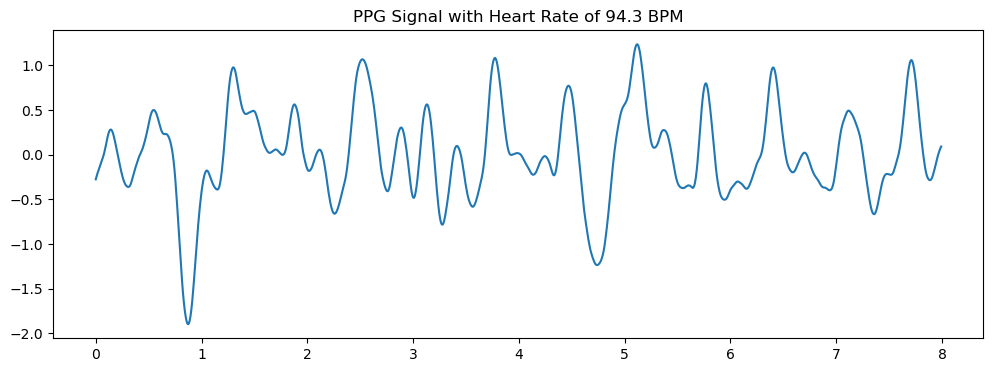

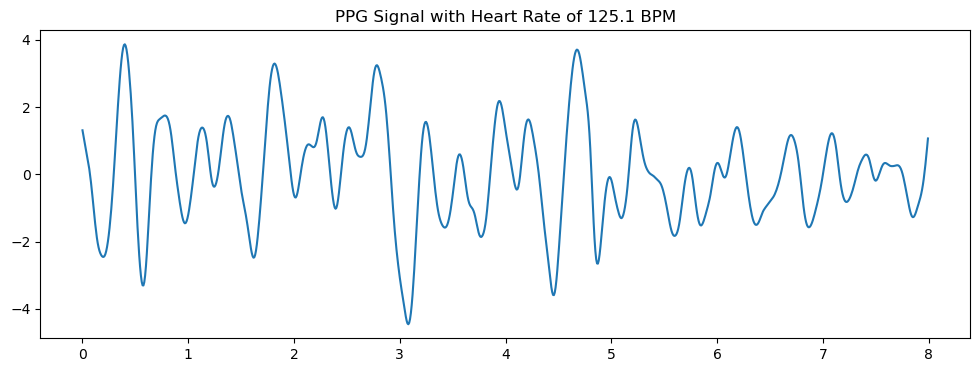

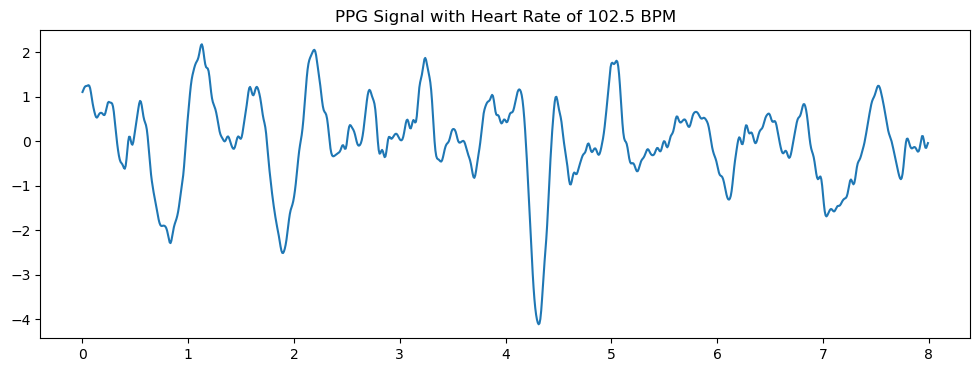

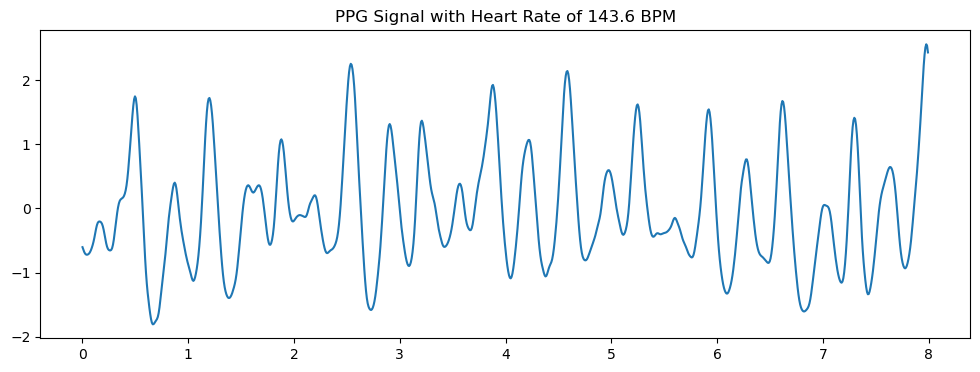

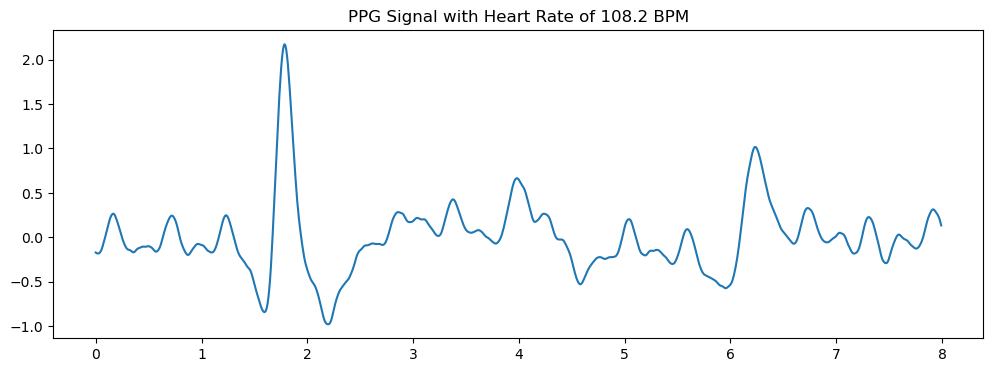

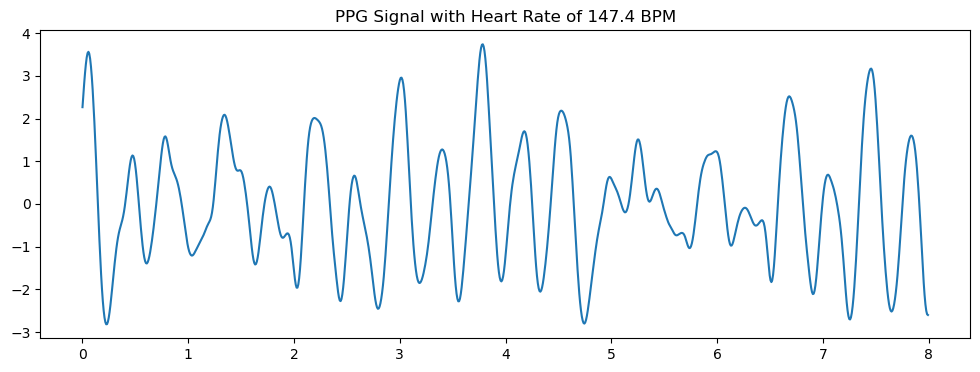

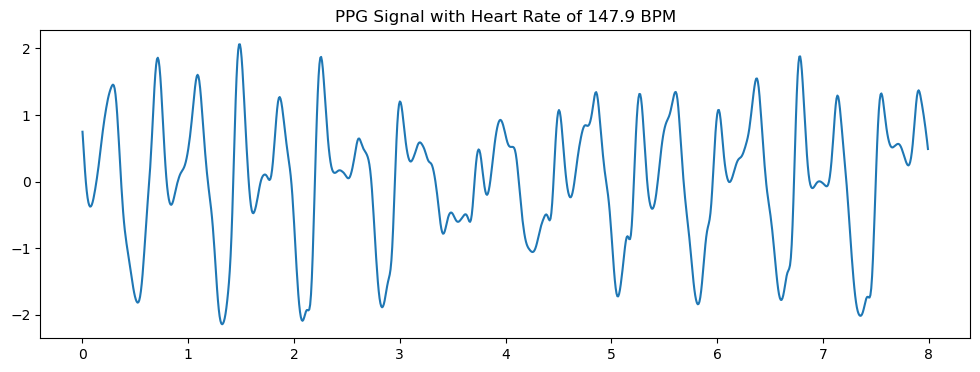

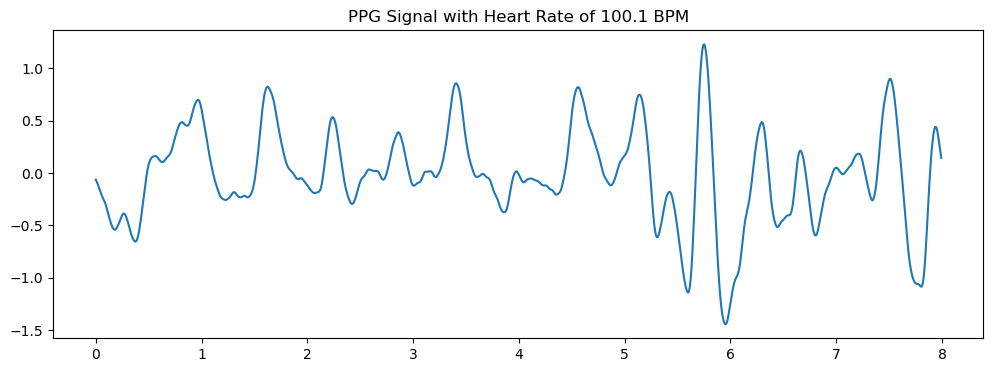

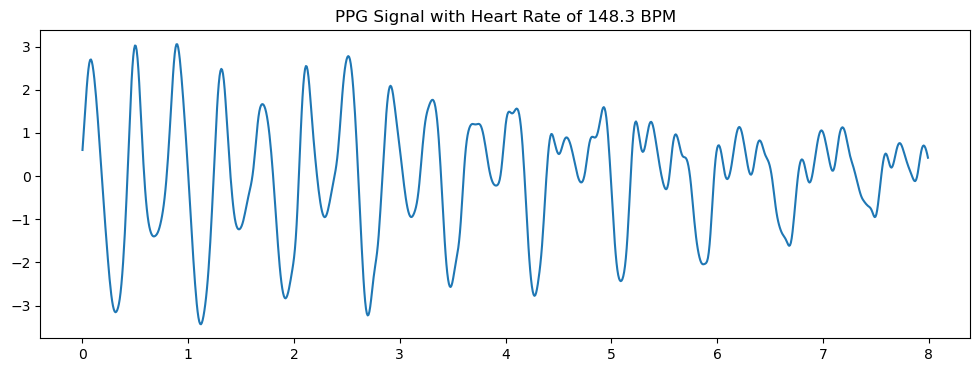

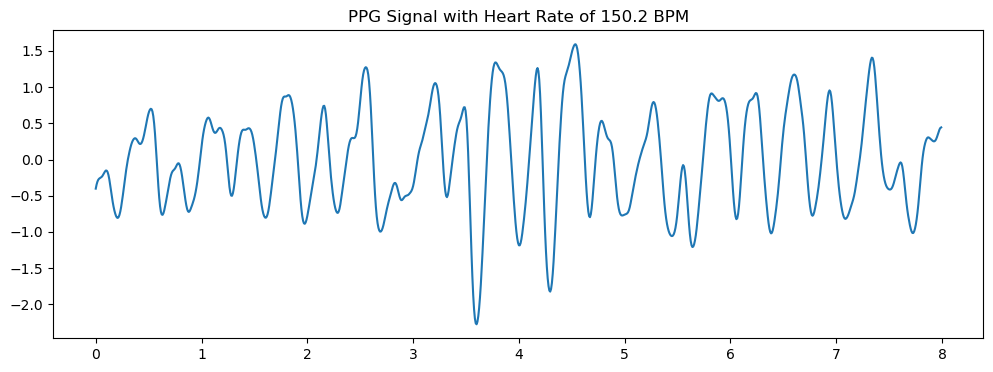

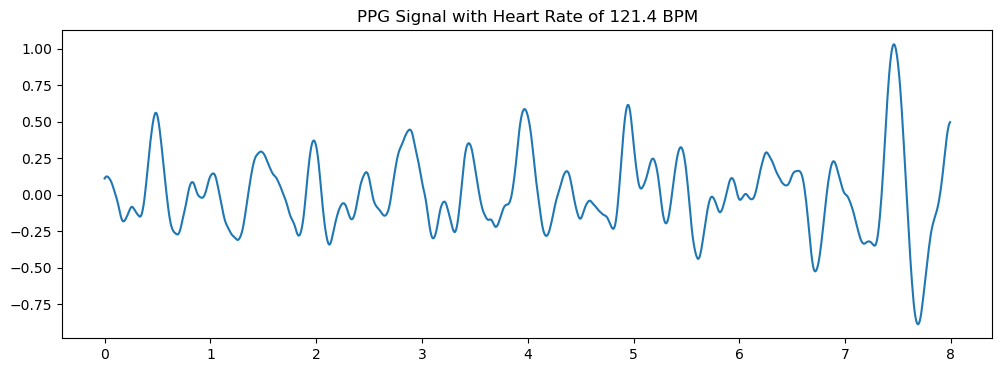

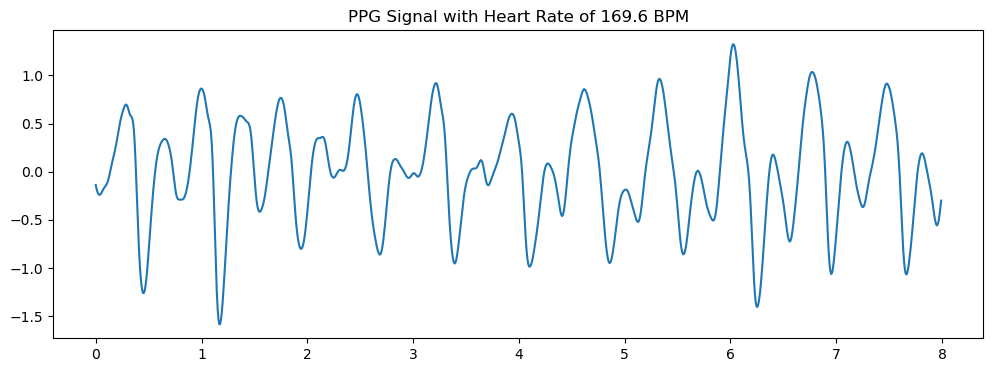

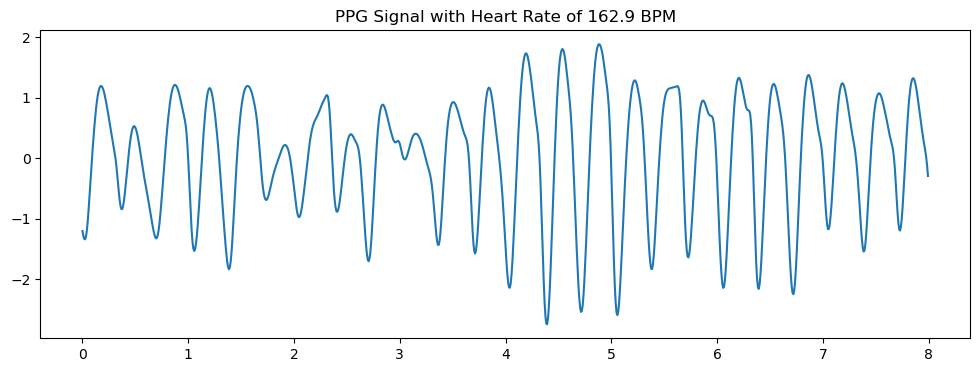

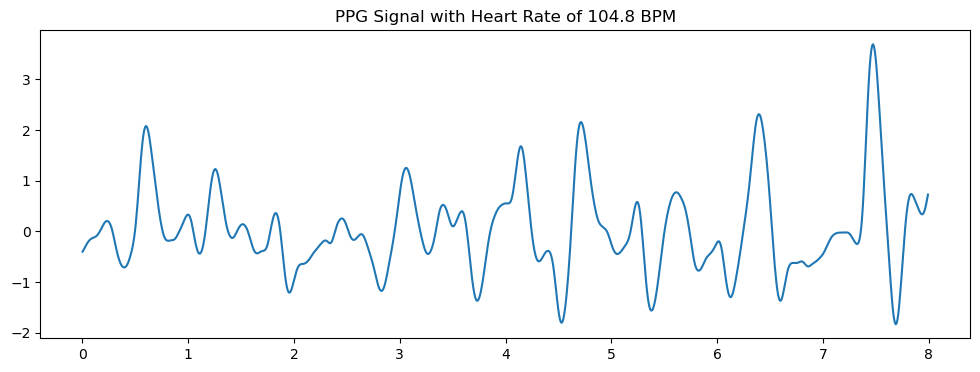

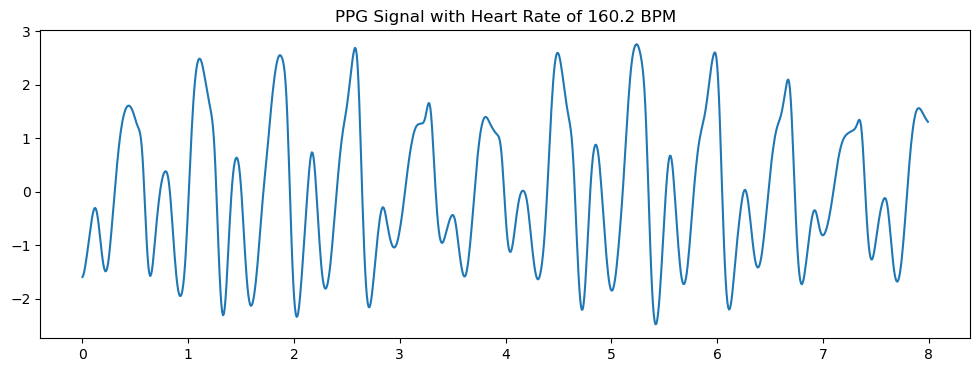

In [22]:
# Create the dataset
dataset = TroikaDataset(data_fls, ref_fls, window_length, window_shift, fs)

# Split the dataset into training and testing
train_size = 0.8
num_train = int(len(dataset) * train_size)
num_test = len(dataset) - num_train
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [num_train, num_test])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Visualize a few of the samples
pltviz = viz(figsize=(12, 4))

cols, rows = 3, 3
for i in range(0, len(dataset), 100):
    # sample_idx = i+(2*(i-1))
    ppg, acc, label = dataset[i]
    ppg_np = ppg.numpy().squeeze()  # Shape is now (window_length,)
    # Create time axis based on sampling frequency
    fs = 125  # Your sampling frequency
    time_axis = np.arange(len(ppg_np)) / fs  # Time in seconds

    pltviz.plot(ppg_np, time_axis,  title=f'PPG Signal with Heart Rate of {label.item():.1f} BPM')
    # visualize_dataset_sample(dataset, sample_idx)

In [23]:
verbose, epochs = 1, 1000
n_timesteps, n_features, n_outputs = len(train_dataset[0][0][0]), 1, 1
learning_rate = 1e-3
batch_size = 32
# epochs = 5

# Initialize the model
model = motionPPGNet(n_timesteps, n_features, n_outputs)
model.to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)



/Users/tmagcaya/miniconda3/envs/torch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [24]:
# Training loop
for epoch in range(epochs):
    model.train()
    for ppg, acc, targets in train_loader:
        inputs, targets = ppg.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:  # Validation every 10 epochs
        model.eval()
        with torch.no_grad():
            total_loss = 0
            for ppg, acc, targets in test_loader:
                inputs, targets = ppg.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                total_loss += loss.item()
            print(f'Epoch {epoch}: Validation Loss: {total_loss / len(test_loader)}')

# In TF Code had about 2 MSE


Epoch 0: Validation Loss: 650.5272605202415
Epoch 10: Validation Loss: 864.0622780539773
Epoch 20: Validation Loss: 298.0904152610085
Epoch 30: Validation Loss: 238.49638921564275
Epoch 40: Validation Loss: 414.692026311701
Epoch 50: Validation Loss: 238.77167788418856
Epoch 60: Validation Loss: 189.13961375843394
Epoch 70: Validation Loss: 110.39463320645419
Epoch 80: Validation Loss: 175.41447726162997
Epoch 90: Validation Loss: 135.33046930486506
Epoch 100: Validation Loss: 726.7608254172585
Epoch 110: Validation Loss: 100.71786811135031
Epoch 120: Validation Loss: 78.350341796875
Epoch 130: Validation Loss: 96.26641082763672
Epoch 140: Validation Loss: 86.6547140641646
Epoch 150: Validation Loss: 95.45963009920987
Epoch 160: Validation Loss: 162.05933310768822
Epoch 170: Validation Loss: 593.3132351962003
Epoch 180: Validation Loss: 247.70647222345525
Epoch 190: Validation Loss: 116.95284964821555
Epoch 200: Validation Loss: 81.52981671420011
Epoch 210: Validation Loss: 73.79330721

In [ ]:
learning_rate = 1e-3
batch_size = 64
epochs = 5

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

loss_fn = nn.MSELoss()
optimizer = torch.optim.adam(model.parameters(), lr=learning_rate)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer)
    test_loop(test_loader, model, loss_fn)
print("Done!")

In [ ]:
# Build the model and evaluate
seed = 42
def split(X, y):
    train_size = 0.8
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=seed)
    return X_train, X_test, y_train, y_test

x_train, x_test, y_train, y_test = split(X, y)

# TODO: Check if any of these change the data in any way
# Reshaping the array to 3-dims so that it can work with the Keras API
x_train = x_train.reshape(x_train.shape[0], 1000, 1)
x_test = x_test.reshape(x_test.shape[0], 1000, 1)
X = X.reshape(X.shape[0], 1000, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
X = X.astype('float32')

# y_train = to_categorical(y_train)
# y_test = to_categorical(y_test)
# y = to_categorical(y)

print('x_train shape:', x_train.shape)
print('Number of segments in x_train', x_train.shape[0])
print('Number of segments in x_test', x_test.shape[0])

print(y_train)


In [ ]:
# fit and evaluate a model (trainX, trainy, testX, testy):
trainX, trainy, testX, testy = x_train, y_train, x_test, y_test
verbose, epochs, batch_size = 1, 1000, 25 # Batch size used to be 32
n_timesteps, n_features, n_outputs = trainX.shape[1], 1, 1
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=40, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=4))
model.add(Dropout(0.1))
model.add(Conv1D(filters=32, kernel_size=40, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=4))
model.add(Dropout(0.1))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(128, return_sequences=True))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='linear'))
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
# fit network
oldtime = time.time()
model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
# model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=verbose)
print("training time:")
print(time.time()-oldtime)
# evaluate model
oldtime = time.time()
_, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)

predictions = model.predict(testX)
testMAE = np.absolute(np.subtract(testy,predictions[:,0])).mean()

predictions = model.predict(X)
totalMAE = np.absolute(np.subtract(y,predictions[:,0])).mean()

print("Test, Total MAE:", str(testMAE), str(totalMAE))
print("testing time:")
print(time.time()-oldtime)
model.summary()

# Notes:
#   - Flatte, Dense 100, rmsprop Test, Total MAE: 33.09671329490874 33.18895348192425
#   - Flatten, Dense 100, adam, Test, Total MAE: 27.908568967205614 28.388384894643007
#   - Flatten, Dense 50, then final neuron, Test, Total RMSE: 134.23943523918422 134.3048856681949
#   - Just found out I had metrics wrong: Train error came down to 0.735 bpm
#   - Test, Total MAE: 2.3047275488171093 1.3646295197764875

In [ ]:
print(predictions.shape)
print(predictions[:,0])
# print(predictions[:,0]-y)

In [ ]:
#Network still needs work before I can really scale it to use the entire dataset. Its too noisey even on its own data.
fig = plt.figure(figsize=(40, 6))
predictions = model.predict(X)
# yhat = savgol_filter(predictions[:,0], 71, 3) # window size 51, polynomial order 3
totalMAE = np.absolute(np.subtract(y,predictions[:,0])).mean()
print("Test, Total MAE:", str(testMAE), str(totalMAE))


# aa=pd.DataFrame(predictions)
# for i in range(50):
#   plt.plot(predictions[:, i])
# # plt.plot(y)
plt.plot(predictions[:,0])
plt.plot(y)
# plt.plot(yhat)
# X1MAE = np.absolute(np.subtract(y1,predictions)).mean()
# plt.title(X1MAE)
plt.show


a = np.zeros(shape=(9999,10))


In [ ]:
print(predictions[:, 1].shape)
plot_model(model, to_file = proj_dir + 'model_plot.png', show_shapes = True, show_layer_names=True)

# print(x_train.shape)
# print(x_train[0].shape)
t = 1200
plt.plot(X[t])
plt.title(y[t])
plt.show()
